# Get the data

In [1]:
import pandas
import numpy as np

In [2]:
dataframe = pandas.read_csv('data.csv', encoding='ISO-8859-1')

dataframe_counts = dataframe.values[:,1:]
dataframe_counts[dataframe_counts == '..'] = 0 # Use zeros to indicate missing data
dataframe_counts = dataframe_counts.astype(np.int)

dataframe.values[:,1:] = dataframe_counts # Replace pesky string integers

data_point_count = dataframe_counts.shape[0]
median_count = np.median(dataframe_counts[dataframe_counts > 0])

years = dataframe.columns[1:]
years = [int(s) for s in years]

names = dataframe.values[:,0]

# Preprocess the data

In [3]:
dataframe_counts_pp = dataframe_counts / median_count # Scaled version of the data

train_data_point_count = int(0.8 * data_point_count)
val_data_point_count = data_point_count - train_data_point_count

data_point_indices = np.arange(data_point_count)
np.random.shuffle(data_point_indices)

train_data_point_indices = data_point_indices[:train_data_point_count]
val_data_point_indices = data_point_indices[train_data_point_count:]

train_dataframe = dataframe_counts_pp[train_data_point_indices,:]
val_dataframe = dataframe_counts_pp[val_data_point_indices,:]

train_names = names[:train_data_point_count]
val_names = names[train_data_point_count:]

# Define the model

In [4]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D

In [5]:
keras.backend.clear_session() # In case you want to get rid of models in RAM

In [6]:
BATCH_SIZE = 32
DATA_DIMENSIONALITY = 1 # Per (lastname, year) there is one piece of data: the count
input_shape = (None, DATA_DIMENSIONALITY)

## Mean Absolute Error (MAE)

In [16]:
model = Sequential([LSTM(64, return_sequences=True, input_shape=input_shape),
                    LSTM(64, return_sequences=True),
                    Dense(1)])

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.MeanAbsoluteError(),
              metrics=['mae'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, None, 64)          16896     
_________________________________________________________________
lstm_9 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense_4 (Dense)              (None, None, 1)           65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


# Creating a custom data generator
Long story short, we want to be able to split our data up into random windows, but with respect to the window's size and locations. This is not feasible to create as a dataset (keeping all possible subsets in RAM is not a good idea). We therefore need a custom data generator.

In [8]:
# Reference:
# https://towardsdatascience.com/implementing-custom-data-generators-in-keras-de56f013581c

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, min_seq_length=3, max_seq_length = None):
        self.data = data
        self.indices = list(range(data.shape[0]))
        self.random_indices = None
        
        self.seq_lengths = data.shape[1]
        self.min_seq_length = min_seq_length
        self.max_seq_length = max_seq_length
        
        self.on_epoch_end()

        if max_seq_length is None:
            self.max_seq_length = self.seq_lengths - 1

    def __len__(self):
        res = len(self.indices) // BATCH_SIZE
        if res == 0 and len(self.indices) > 0:
            res = 1
        return res

    def __getitem__(self, index):
        random_indices_batch = self.random_indices[index * BATCH_SIZE : (index + 1) * BATCH_SIZE]
        window_size_batch = np.random.randint(self.min_seq_length, high=self.max_seq_length)
        window_offsets_batch = np.random.randint(0, high=(self.seq_lengths - window_size_batch), size=BATCH_SIZE)
        
        X = np.zeros((BATCH_SIZE, window_size_batch, DATA_DIMENSIONALITY))
        Y = np.zeros((BATCH_SIZE, window_size_batch, DATA_DIMENSIONALITY))

        for i in range(BATCH_SIZE):
            i_r = random_indices_batch[i]
            w_o = window_offsets_batch[i]
            
            start_index = w_o
            stop_index = w_o + window_size_batch
            
            X[i, :, :] = np.expand_dims(self.data[i_r, start_index:stop_index], axis=-1)
            Y[i, :, :] = np.expand_dims(self.data[i_r, start_index+1:stop_index+1], axis=-1)
        
        return X, Y

    def on_epoch_end(self):
        random_indices_length = np.maximum(BATCH_SIZE, len(self.indices))
        self.random_indices = np.random.randint(0, high=len(self.indices), size=random_indices_length)

# Fitting the model

Possible improvements:
* Implement checkpoints
* Implement early stopping

In [17]:
dg_train = DataGenerator(train_dataframe, min_seq_length=20)
dg_val = DataGenerator(val_dataframe, min_seq_length=20)

history = model.fit(dg_train, validation_data=dg_val, epochs=200)

Epoch 1/200
2/2 [==============================] - 3s 658ms/step - loss: 3.2256 - mae: 3.0882 - val_loss: 0.9816 - val_mae: 0.9816
Epoch 2/200
2/2 [==============================] - 0s 65ms/step - loss: 1.7228 - mae: 1.5630 - val_loss: 0.6095 - val_mae: 0.6095
Epoch 3/200
2/2 [==============================] - 0s 71ms/step - loss: 0.9382 - mae: 0.9351 - val_loss: 3.2604 - val_mae: 3.2604
Epoch 4/200
2/2 [==============================] - 0s 67ms/step - loss: 0.7919 - mae: 0.7898 - val_loss: 1.6337 - val_mae: 1.6337
Epoch 5/200
2/2 [==============================] - 0s 71ms/step - loss: 0.9227 - mae: 0.9042 - val_loss: 1.8050 - val_mae: 1.8050
Epoch 6/200
2/2 [==============================] - 0s 64ms/step - loss: 1.4656 - mae: 1.4786 - val_loss: 1.0404 - val_mae: 1.0404
Epoch 7/200
2/2 [==============================] - 0s 74ms/step - loss: 0.8126 - mae: 0.8108 - val_loss: 1.3999 - val_mae: 1.3999
Epoch 8/200
2/2 [==============================] - 0s 72ms/step - loss: 1.0939 - mae: 1.0

2/2 [==============================] - 0s 86ms/step - loss: 0.1199 - mae: 0.1197 - val_loss: 0.3198 - val_mae: 0.3198
Epoch 64/200
2/2 [==============================] - 0s 75ms/step - loss: 0.1747 - mae: 0.1743 - val_loss: 0.7783 - val_mae: 0.7783
Epoch 65/200
2/2 [==============================] - 0s 68ms/step - loss: 0.5728 - mae: 0.5853 - val_loss: 0.8388 - val_mae: 0.8388
Epoch 66/200
2/2 [==============================] - 0s 81ms/step - loss: 0.0986 - mae: 0.0957 - val_loss: 0.5641 - val_mae: 0.5641
Epoch 67/200
2/2 [==============================] - 0s 76ms/step - loss: 0.1356 - mae: 0.1335 - val_loss: 0.7633 - val_mae: 0.7633
Epoch 68/200
2/2 [==============================] - 0s 70ms/step - loss: 0.3541 - mae: 0.3717 - val_loss: 0.0835 - val_mae: 0.0835
Epoch 69/200
2/2 [==============================] - 0s 73ms/step - loss: 0.2716 - mae: 0.2767 - val_loss: 0.0703 - val_mae: 0.0703
Epoch 70/200
2/2 [==============================] - 0s 77ms/step - loss: 0.1668 - mae: 0.1625 - 

2/2 [==============================] - 0s 75ms/step - loss: 0.0911 - mae: 0.0919 - val_loss: 0.1046 - val_mae: 0.1046
Epoch 126/200
2/2 [==============================] - 0s 82ms/step - loss: 0.1973 - mae: 0.1952 - val_loss: 0.2010 - val_mae: 0.2010
Epoch 127/200
2/2 [==============================] - 0s 71ms/step - loss: 0.2635 - mae: 0.2692 - val_loss: 0.2787 - val_mae: 0.2787
Epoch 128/200
2/2 [==============================] - 0s 70ms/step - loss: 0.2053 - mae: 0.2098 - val_loss: 0.3397 - val_mae: 0.3397
Epoch 129/200
2/2 [==============================] - 0s 78ms/step - loss: 0.1790 - mae: 0.1752 - val_loss: 0.2245 - val_mae: 0.2245
Epoch 130/200
2/2 [==============================] - 0s 73ms/step - loss: 0.1415 - mae: 0.1461 - val_loss: 0.3999 - val_mae: 0.3999
Epoch 131/200
2/2 [==============================] - 0s 78ms/step - loss: 0.1812 - mae: 0.1711 - val_loss: 0.0520 - val_mae: 0.0520
Epoch 132/200
2/2 [==============================] - 0s 64ms/step - loss: 0.3767 - mae: 0.

2/2 [==============================] - 0s 75ms/step - loss: 0.1244 - mae: 0.1176 - val_loss: 0.1079 - val_mae: 0.1079
Epoch 188/200
2/2 [==============================] - 0s 71ms/step - loss: 0.1324 - mae: 0.1333 - val_loss: 0.0379 - val_mae: 0.0379
Epoch 189/200
2/2 [==============================] - 0s 62ms/step - loss: 0.1321 - mae: 0.1330 - val_loss: 0.2668 - val_mae: 0.2668
Epoch 190/200
2/2 [==============================] - 0s 69ms/step - loss: 0.0554 - mae: 0.0553 - val_loss: 0.0549 - val_mae: 0.0549
Epoch 191/200
2/2 [==============================] - 0s 68ms/step - loss: 0.1131 - mae: 0.1111 - val_loss: 0.0394 - val_mae: 0.0394
Epoch 192/200
2/2 [==============================] - 0s 86ms/step - loss: 0.0421 - mae: 0.0416 - val_loss: 0.2774 - val_mae: 0.2774
Epoch 193/200
2/2 [==============================] - 0s 75ms/step - loss: 0.1140 - mae: 0.1061 - val_loss: 0.1385 - val_mae: 0.1385
Epoch 194/200
2/2 [==============================] - 0s 70ms/step - loss: 0.1745 - mae: 0.

# Plot the results

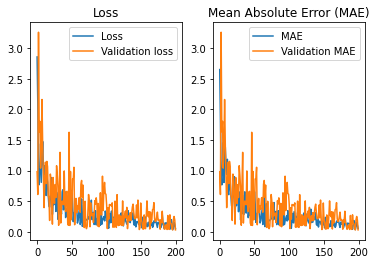

In [18]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.title("Mean Absolute Error (MAE)")
plt.plot(history.history['mae'], label='MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend(loc='upper right')

plt.show()

# Make predictions

In [24]:
print("Available names:")
print(", ".join(list(val_names)))

Available names:
Pettersson, Pålsson, Samuelsson, Sandberg, Sandström, Sjöberg, Sjögren, Ström, Strömberg, Sundberg, Sundqvist, Sundström, Svensson, Söderberg, Söderström, Wallin, Viklund, Wikström, Åberg, Åkesson, Åström, Öberg


In [25]:
name = "Sjöberg"
svensson_index = np.argwhere(val_names == name)[0][0]

svensson_data = np.copy(val_dataframe[svensson_index,:])
svensson_data = np.expand_dims(svensson_data, axis=0)
svensson_data = np.expand_dims(svensson_data, axis=-1)

prediction_count = 11

predictions = np.zeros(prediction_count)
current_window = svensson_data

for i in range(prediction_count):
    current_window = model.predict(current_window)
    predictions[i] = current_window[0, -1, 0]
    
svensson_data *= median_count
predictions *= median_count

svensson_data = np.squeeze(svensson_data)

# Plot predictions

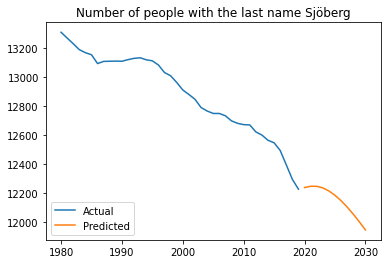

In [26]:
prediction_years = list(range(years[-1] + 1, years[-1] + 1 + prediction_count))

plt.title("Number of people with the last name {}".format(name))
plt.plot(years, svensson_data, label='Actual')
plt.plot(prediction_years, predictions, label='Predicted')
plt.legend(loc='lower left')

plt.show()

# Sidenote: finding a nice learning rate
In short: results do not seem to be very dependent on learning rate in this case

In [27]:
model = Sequential([LSTM(64, return_sequences=True, input_shape=input_shape),
                    LSTM(64, return_sequences=True),
                    Dense(1)])

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.MeanAbsoluteError(),
              metrics=['mae'])

lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

dg_train = DataGenerator(train_dataframe, min_seq_length=20)

history = model.fit(dg_train, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
2/2 [==============================] - 3s 23ms/step - loss: 1.5833 - mae: 1.5992
Epoch 2/100
2/2 [==============================] - 0s 23ms/step - loss: 1.8447 - mae: 1.8571
Epoch 3/100
2/2 [==============================] - 0s 27ms/step - loss: 2.5198 - mae: 2.5346
Epoch 4/100
2/2 [==============================] - 0s 19ms/step - loss: 2.4156 - mae: 2.4185
Epoch 5/100
2/2 [==============================] - 0s 30ms/step - loss: 2.3389 - mae: 2.3413
Epoch 6/100
2/2 [==============================] - 0s 25ms/step - loss: 2.7995 - mae: 2.7988
Epoch 7/100
2/2 [==============================] - 0s 23ms/step - loss: 2.0399 - mae: 2.0384
Epoch 8/100
2/2 [==============================] - 0s 33ms/step - loss: 1.3896 - mae: 1.3963
Epoch 9/100
2/2 [==============================] - 0s 23ms/step - loss: 1.9694 - mae: 1.9882
Epoch 10/100
2/2 [==============================] - 0s 28ms/step - loss: 1.3908 - mae: 1.4160
Epoch 11/100
2/2 [==============================] - 0s 21ms/step - lo

2/2 [==============================] - 0s 31ms/step - loss: 2.0893 - mae: 2.0404
Epoch 89/100
2/2 [==============================] - 0s 26ms/step - loss: 1.5677 - mae: 1.5876
Epoch 90/100
2/2 [==============================] - 0s 27ms/step - loss: 0.9934 - mae: 0.9817
Epoch 91/100
2/2 [==============================] - 0s 21ms/step - loss: 1.3760 - mae: 1.3775
Epoch 92/100
2/2 [==============================] - 0s 26ms/step - loss: 1.7587 - mae: 1.7320
Epoch 93/100
2/2 [==============================] - 0s 19ms/step - loss: 1.4339 - mae: 1.4543
Epoch 94/100
2/2 [==============================] - 0s 24ms/step - loss: 1.8982 - mae: 1.8927
Epoch 95/100
2/2 [==============================] - 0s 19ms/step - loss: 1.4398 - mae: 1.4053
Epoch 96/100
2/2 [==============================] - 0s 26ms/step - loss: 1.1744 - mae: 1.1744
Epoch 97/100
2/2 [==============================] - 0s 23ms/step - loss: 0.5761 - mae: 0.5650
Epoch 98/100
2/2 [==============================] - 0s 24ms/step - loss: 

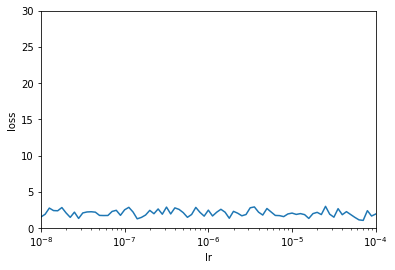

In [28]:
import matplotlib.pyplot as plt

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])
plt.xlabel("lr")
plt.ylabel("loss")
plt.show()